In [150]:
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
plt.style.use('seaborn')

In [2]:
def div(cx,cy):
    #cy and cy are coordonates of a vector field.
    #the function compute the discrete divergence of this vector field

    nr,nc=cx.shape

    ddx=np.zeros((nr,nc))
    ddy=np.zeros((nr,nc))

    ddx[:,1:-1]=cx[:,1:-1]-cx[:,0:-2]
    ddx[:,0]=cx[:,0]
    ddx[:,-1]=-cx[:,-2]
  
    ddy[1:-1,:]=cy[1:-1,:]-cy[0:-2,:]
    ddy[0,:]=cy[0,:]
    ddy[-1,:]=-cy[-2,:]
 
    d=ddx+ddy

    return d

In [3]:
def grad(im):
    #compute the gradient of the image 'im'
    # image size 
    nr,nc=im.shape
  
    gx = im[:,1:]-im[:,0:-1]
    gx = np.block([gx,np.zeros((nr,1))])

    gy =im[1:,:]-im[0:-1,:]
    gy=np.block([[gy],[np.zeros((1,nc))]])
    return gx,gy

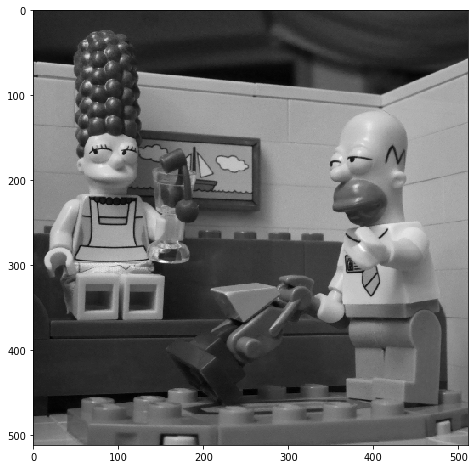

In [4]:
u = plt.imread('../im/simpson512.png')    # images can be found here https://github.com/judelo/notebooks/tree/master/im
u = u[:,:,1]
plt.figure(figsize = (8,8))
plt.imshow(u, cmap = 'gray')

In [5]:
s=4 #kernel definition    (for a 9x9 uniform kernel)
h = np.zeros((u.shape[0],u.shape[1]))
h[0:2*s+1,0:2*s+1] = np.ones((2*s+1, 2*s+1))/(2*s+1)**2

In [6]:
convol  = lambda a,b:  np.real(np.fft.ifft2(np.fft.fft2(a)*np.fft.fft2(b)))

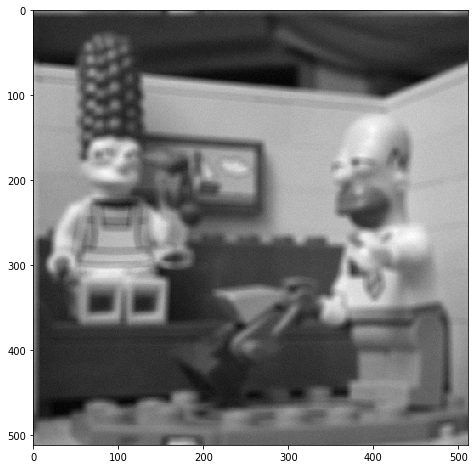

In [7]:
# blurred image
ub = convol(u,h) + 0.01*np.random.randn(u.shape[0],u.shape[1])
plt.figure(figsize = (8,8))
plt.imshow(ub, cmap = 'gray')

In [9]:
def convol(a,b):
    return np.real(np.fft.ifft2(np.fft.fft2(a)*np.fft.fft2(b))) 

def IdplustauATA_inv(x,tau,h): 
    return np.real(np.fft.ifft2(np.fft.fft2(x)/(1+tau*np.abs(np.fft.fft2(h))**2)))

def chambolle_pock_prox_TV(ub,lambd,niter):
    # the function solves the problem
    # argmin_u   1/2 \| u - ub\|^2 + \lambda TV(u)
    # with TV(u) = \sum_i \|\nabla u (i) \|_2
    # uses niter iterations of Chambolle-Pock
    
    nr,nc = ub.shape
    ut = np.copy(ub)
    ubar = np.copy(ut)
    p = np.zeros((nr,nc,2))
    tau   = 0.9/np.sqrt(8*lambd**2)
    sigma = 0.9/np.sqrt(8*lambd**2) 
    theta = 1
    
    for k in range(niter):
        # calcul de proxF
        ux,uy  = grad(ubar)
        p = p + sigma*lambd*np.stack((ux,uy),axis=2)
        normep = np.sqrt(p[:,:,0]**2+p[:,:,1]**2)
        normep = normep*(normep>1) + (normep<=1)
        p[:,:,0] = p[:,:,0]/normep
        p[:,:,1] = p[:,:,1]/normep

        # calcul de proxG
        d=div(p[:,:,0],p[:,:,1])
        #TVL2
        unew = 1/(1+tau)*(ut+tau*lambd*d+tau*ub) 
        
        #extragradient step
        ubar = unew+theta*(unew-ut)
        ut = unew
    return ut

def chambolle_pock_deblurring_TV(ub,h,lambd,niter):
    # the function solves the problem
    # argmin_u   1/2 \| Au - ub\|^2 + \lambda TV(u)
    # with TV(u) = \sum_i \|\nabla u (i) \|_2
    # and A = blur given by a kernel h
    # uses niter iterations of Chambolle-Pock

    nr,nc = ub.shape
    ut = np.copy(ub)

    p = np.zeros((nr,nc,2))
    tau   = 0.9/np.sqrt(8*lambd**2)
    sigma = 0.9/np.sqrt(8*lambd**2) 
    theta = 1
    ubar = np.copy(ut)
    
    h_fft = np.fft.fft2(h)
    hc_fft = np.conj(h_fft)
    hc = np.fft.ifft2(hc_fft)


    for k in range(niter):
        
        # subgradient step on p 
        ux,uy  = grad(ubar)
        p = p + sigma*lambd*np.stack((ux,uy),axis=2)
        normep = np.sqrt(p[:,:,0]**2+p[:,:,1]**2)
        normep = normep*(normep>1) + (normep<=1)
        p[:,:,0] = p[:,:,0]/normep
        p[:,:,1] = p[:,:,1]/normep
        
    # subgradient step on u
        d=div(p[:,:,0],p[:,:,1])
        unew = (ut+tau*lambd*d+tau*convol(ub, hc)) 
        unew = IdplustauATA_inv(unew, tau,h)
    
    #extragradient step on u 
        ubar = unew+theta*(unew-ut)
        ut = unew
        
    return ut


In [58]:
def f_y(x, y, h, sigma):
    return np.linalg.norm(y - convol(x,h))**2/(2*sigma**2)

def TV(u):
    return  np.sum(np.sqrt((np.roll(u,1,axis=0)- u)**2+(np.roll(u,1,axis=1) - u)**2))

In [59]:
def MYULA_update(x, y, theta, gamma, lbd, h, sigma):
    
    h_fft = np.fft.fft2(h)
    hc_fft = np.conj(h_fft)
    hc = np.fft.ifft2(hc_fft)
    grad_f_y = (1/sigma**2)*convol(convol(x,h)-y,hc)
    
    prox = chambolle_pock_prox_TV(x,lbd*theta,25)
    
    z = np.random.randn(x.shape[0],x.shape[1])
    
    x_new = x - gamma*grad_f_y - gamma*(x - prox)/lbd + (2*gamma)**0.5*z
    
    return x_new

In [117]:
def test_sampler(y, theta, gamma, lbd, h, sigma, niter):
    
    x = np.copy(y)
    
    log_p_hist = []
    
    for n in range(niter):
        
        log_p_hist.append(-f_y(x, y, h, sigma)-theta*TV(x))
        
        x = MYULA_update(x, y, theta, gamma, lbd, h, sigma)
        
    return log_p_hist

Text(0, 0.5, 'log p x$10^{6}$')

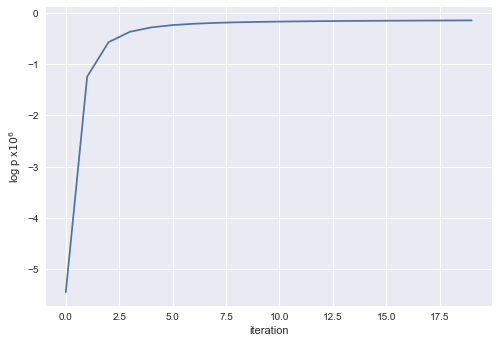

In [129]:
y = ub
theta0 = 0.01
sigma = 0.01
eps = 0.001
x0 = y

L = (0.99/sigma)**2
lbd = min(5/L, 2)
gamma = 0.98/(L+1/lbd)

log_p_hist = np.asarray(test_sampler(y, theta0, gamma, lbd, h, sigma, 20))

plt.plot(log_p_hist/10**6)
plt.xlabel('iteration')
plt.ylabel('log p x$10^{6}$')

Text(0, 0.5, 'log p x$10^{6}$')

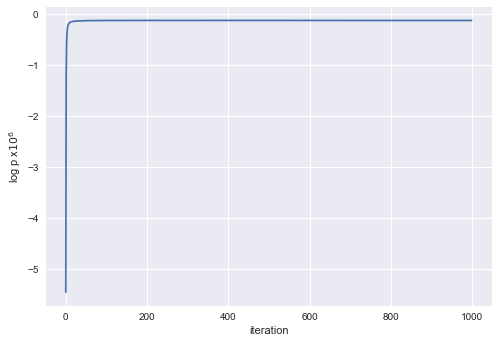

In [130]:
log_p_hist = np.asarray(test_sampler(y, theta0, gamma, lbd, h, sigma, 1000))

plt.plot(log_p_hist/10**6)
plt.xlabel('iteration')
plt.ylabel('log p x$10^{6}$')

Text(0, 0.5, 'log p x$10^{6}$')

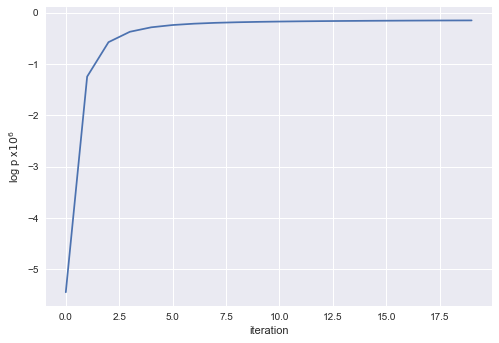

In [133]:
log_p_hist = np.asarray(test_sampler(y, 0.1, gamma, lbd, h, sigma, 20))

plt.plot(log_p_hist/10**6)
plt.xlabel('iteration')
plt.ylabel('log p x$10^{6}$')

Text(0, 0.5, 'log p x$10^{6}$')

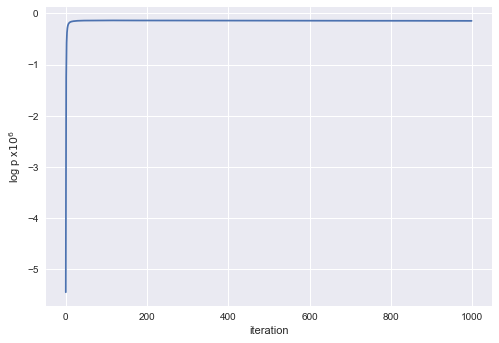

In [134]:
log_p_hist = np.asarray(test_sampler(y, 0.1, gamma, lbd, h, sigma, 1000))

plt.plot(log_p_hist/10**6)
plt.xlabel('iteration')
plt.ylabel('log p x$10^{6}$')

In [87]:
def algo1(x0, theta0, sigma, y, h, lbd, gamma, eps=0.001):
    
    theta = theta0
    
    x = np.copy(x0)
    
    theta_hist = []
    theta_avg_hist = []
    
    d = x0.shape[0]*x0.shape[1]
    
    for n in range(27):
        
        x = MYULA_update(x, y, theta, gamma, lbd, h, sigma)
        
        delta = 0.1 * (n+1)**(-0.8)/d
        theta = theta + delta*(d/theta - TV(x))
        
        theta_hist.append(theta)
    
    n = 27
    N0 = 25
    
    theta_avg_hist.append(theta_hist[-2])
    theta_avg_hist.append(0.5*(theta_hist[-2]+theta_hist[-1]))
    
    err = abs(theta_avg_hist[-1] - theta_avg_hist[-2])
    
    while err>eps:
        
        x = MYULA_update(x, y, theta, gamma, lbd, h, sigma)
        
        delta = 0.1 * (n+1)**(-0.8)/d
        theta = theta + delta*(d/theta - TV(x))
        
        theta_hist.append(theta)
        
        n += 1
        
        theta_avg_hist.append((1/(n - N0))*sum(theta_hist[N0:]))
        
        err = abs(theta_avg_hist[-1] - theta_avg_hist[-2])
        
    return theta_hist, theta_avg_hist

In [135]:
theta_hist_eps1, theta_opt_hist_eps1 = algo1(x0, theta0, sigma, y, h, lbd, gamma)

In [136]:
print(theta_opt_hist_eps1)

[10.02229831869939, 10.022332708722416]


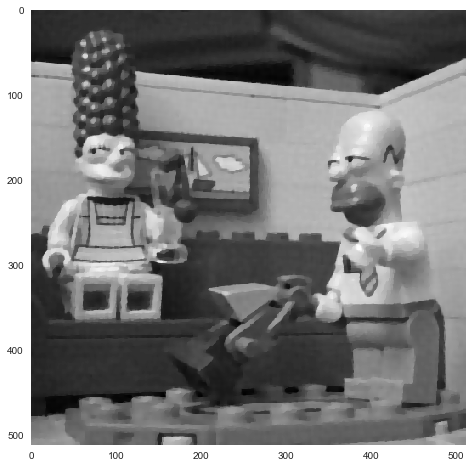

In [152]:
niter = 200

# TVL2 deblurring
x_eps1 = chambolle_pock_deblurring_TV(y,h,sigma**2*theta_opt_hist_eps1[-1],niter) 

#display result

sns.set_style("white")

plt.figure(figsize = (8,8))
plt.imshow(x_eps1,cmap='gray')

Text(0, 0.5, 'iteration')

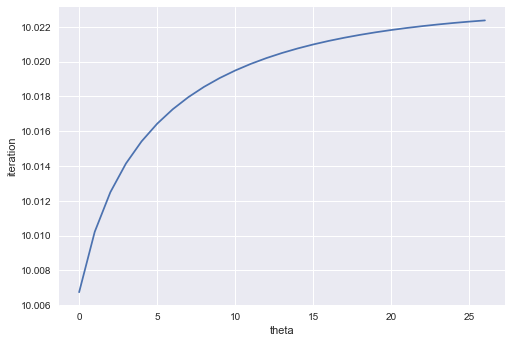

In [138]:
sns.set()

plt.plot(np.asarray(theta_hist_eps1))
plt.xlabel('theta')
plt.ylabel('iteration')

[10.022292630786586, 10.022326052530554, 10.022357153824856, 10.022386044111824, 10.022412945068968, 10.0224378740191, 10.022460872630004, 10.022482008570105, 10.022501416779226, 10.022519285054896, 10.022535699857267, 10.022550754459463, 10.022564504256062, 10.022577014781787, 10.022588362893057, 10.022598601087884, 10.022607801148226]


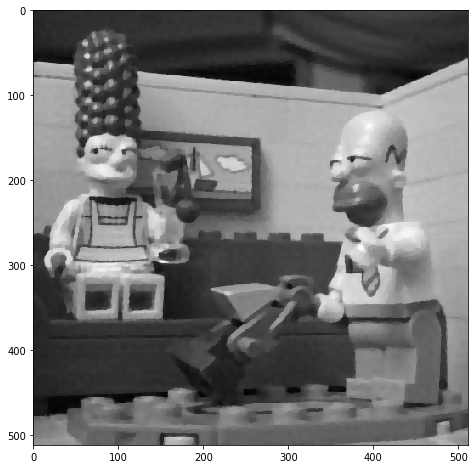

In [95]:
eps = 0.00001

theta_hist_eps2, theta_opt_hist_eps2 = algo1(x0, theta0, sigma, y, h, lbd, gamma, eps)

print(theta_opt_hist_eps2)

niter = 200

# TVL2 deblurring
x_eps2 = chambolle_pock_deblurring_TV(y,h,sigma**2*theta_opt_hist_eps2[-1],niter) 

#display result

sns.set_style("white")

plt.figure(figsize = (8,8))
plt.imshow(x_eps2,cmap='gray')

Text(0, 0.5, 'theta')

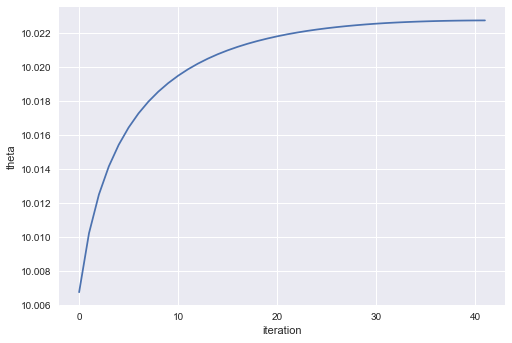

In [125]:
sns.set()

plt.plot(np.asarray(theta_hist_eps2))
plt.xlabel('iteration')
plt.ylabel('theta')

In [98]:
theta_list = np.logspace(-6, 0, num=100)

list_mse = []

for theta in theta_list:
    
    list_mse.append(np.linalg.norm(u-chambolle_pock_deblurring_TV(y,h,theta,niter)))
    


Text(0, 0.5, 'mse')

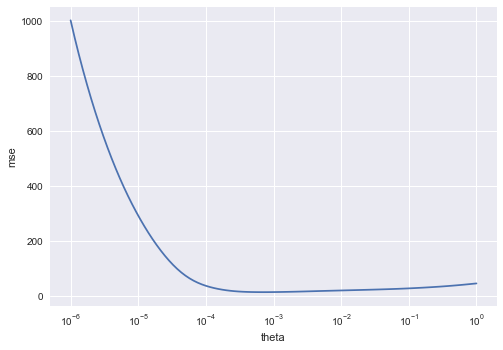

In [124]:
plt.plot(theta_list, list_mse)
plt.xscale('log')
plt.xlabel('theta')
plt.ylabel('mse')

In [153]:
mse_eps1 = np.linalg.norm(u-x_eps1)
mse_eps2 = np.linalg.norm(u-x_eps2)

print(mse_eps1)
print(mse_eps2)
print(np.min(np.asarray(list_mse)))

13.88984926857549
13.889882108123984
13.653480843933929


Text(0, 0.5, 'mse')

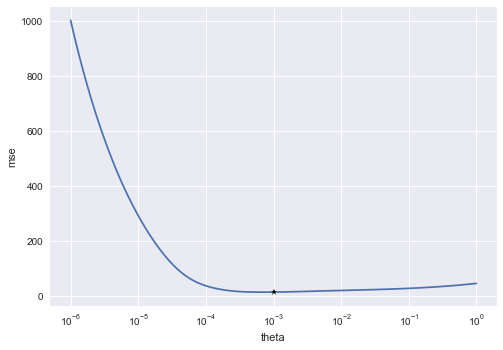

In [147]:
plt.plot(theta_list, list_mse)
plt.plot(sigma**2*theta_opt_hist_eps1[-1], mse_eps1, c="k", marker="*")
plt.xscale('log')
plt.xlabel('theta')
plt.ylabel('mse')

In [112]:
print(theta_list[np.argmin(np.asarray(list_mse))])

0.0007054802310718645


In [142]:
print(sigma**2*theta_opt_hist_eps1[-1])

0.0010022332708722417


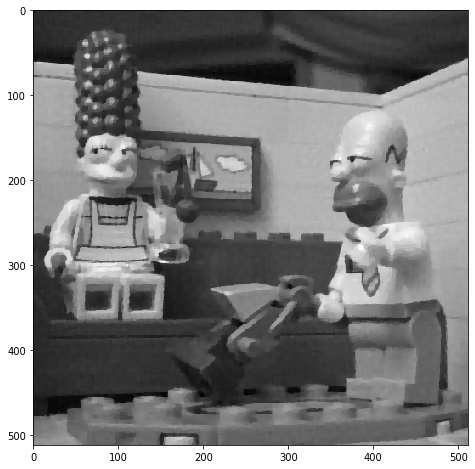

In [114]:
# TVL2 deblurring
x_best_mse = chambolle_pock_deblurring_TV(y,h,theta_list[np.argmin(np.asarray(list_mse))],200) 

#display result

sns.set_style("white")

plt.figure(figsize = (8,8))
plt.imshow(x_best_mse,cmap='gray')